# Neural Style Transfer from scratch
Yuan Gao @UCSD

There are a lot of existing NST libraries/modules avaible for Python, but **for the sake of understanding it and understanding how Deep CNN works in terms of identifing features**, I build this project almost from scratch(here I downloaded pretrained data for my own model to increase efficiency and save training time)

## Model overview
* Model: VGG-19 network, a 19-layer VGG network

- the content cost function$J_{content}(C,G)$
$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$
- the style cost function $J_{style}(S,G)$
$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$
- Cumulatively, $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 

* Optimizer: Adam optimizer with step 2.0
* Style Weights: 0.2 for each layer

In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

## Transfer learning
In order to increase efficiency and save training time, I used pretrained model from 

In [2]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

W1004 14:27:56.477463 4474119616 deprecation_wrapper.py:119] From /Users/rabona/Documents/deeplearning/04.卷积神经网络/第四周 特殊应用：人脸识别和神经风格转换/编程作业/Neural Style Transfer/nst_utils.py:124: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



## The content cost and the style cost

In [3]:
def compute_content_cost(a_C, a_G):
    (m, n_H, n_W, n_C) = a_G.get_shape().as_list()
    a_C_reshaped = tf.reshape(a_C, [n_H*n_W, n_C])
    a_G_reshaped = tf.reshape(a_G, [n_H*n_W, n_C])
    
    J_content = tf.reduce_sum(tf.square(a_C_reshaped-a_G_reshaped), [0,1])/(4*n_H*n_W*n_C)
    return J_content

### The Gram matrix and how does it work
First, **how can we detect style?**
we use the corelation accross different channels in a layer to define Style.

To compare how two matrixes are correlated, and in this project, how two channels in a layer are correlated, we use their dot product, and more formally, we unroll the image and compute the ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$

<img src="images/NST_GM.png" style="width:900px;height:300px;">

In [4]:
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))
    return GA

In [5]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
   
    (m, n_H, n_W, n_C) = a_G.get_shape().as_list()
    
    a_S_reshaped = tf.reshape(a_S, [n_H*n_W, n_C])
    a_G_reshaped = tf.reshape(a_G, [n_H*n_W, n_C])
    
    GS = gram_matrix(tf.transpose(a_S_reshaped))
    GG = gram_matrix(tf.transpose(a_G_reshaped))
    
    J_style_layer = tf.reduce_sum(tf.square(GS-GG),[0,1]) / (4 * n_C**2 * (n_W * n_H)**2)
    
    return J_style_layer

In [6]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [7]:
def compute_style_cost(model, STYLE_LAYERS):
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:
        # Select the output tensor of the currently selected layer
        out = model[layer_name]
        a_S = sess.run(out)
        a_G = out        
        J_style_layer = compute_layer_style_cost(a_S, a_G)
        J_style += coeff * J_style_layer

    return J_style

def total_cost(J_content, J_style, alpha = 10, beta = 40):
    
    J = alpha*J_content + beta*J_style
    return J

In [8]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


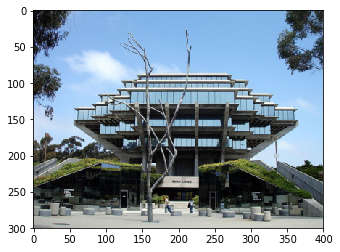

In [10]:
content_image = scipy.misc.imresize(scipy.misc.imread("images/geisal.jpg"), size= (300,400,3))
imshow(content_image)
content_image = reshape_and_normalize_image(content_image)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


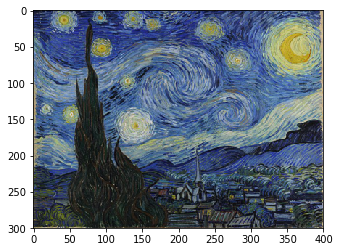

In [11]:
style_image = scipy.misc.imresize(scipy.misc.imread("images/starry-night-style.jpg"), size= (300,400,3))
imshow(style_image)
style_image = reshape_and_normalize_image(style_image)

W1004 14:54:24.698109 4474119616 image.py:663] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


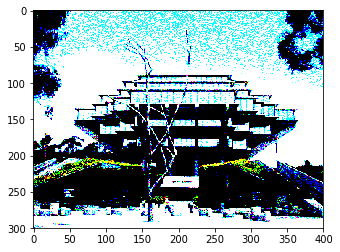

In [12]:
#randomly generate a picture for training
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [13]:
# Transfer learning
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

## Now ihere the step howwe are actually going to put piece together and train the model

1. Initializing the first generated picture using content
2. Load the VGG16 model for transfer learning
3. Run the content image through the VGG16 model and take out one layer to compute the activation(turns out the middle layer works). Why only one layerAccording to deeplearning.ai: 

<font color='blue'>
**What you should remember**:
- The style of an image can be represented using the Gram matrix of a hidden layer's activations. However, we get even better results combining this representation from multiple different layers. This is in contrast to the content representation, where usually using just a single hidden layer is sufficient.
- Minimizing the style cost will cause the image $G$ to follow the style of the image $S$. 
</font color='blue'>

4. Run the style image through the VGG16 model and compute the style cost(according to the weights)
5. Compute the total cost
6. Define the optimizer and the learning rate
7. Initialize the TensorFlow graph and train it.

## Here for building the tensorflow graph I asked for help cuz sometimes its tricky

In [16]:
## Preparing for training
sess.run(model['input'].assign(content_image))
out = model['conv4_2']
a_C = sess.run(out)
a_G = out
# Compute the content cost
J_content = compute_content_cost(a_C, a_G)
sess.run(model['input'].assign(style_image))
J_style = compute_style_cost(model, STYLE_LAYERS)

J = total_cost(J_content,J_style,10,40)

In [17]:
optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(J)

## Here comes the final model

In [18]:
def model_nn(sess, input_image, num_iterations = 200):
    
    sess.run(tf.global_variables_initializer())
    sess.run(model['input'].assign(input_image))
    for i in range(num_iterations):        
        sess.run(train_step)
        generated_image = sess.run(model['input'])
        #Making sure its working
        if i%10 == 0:
            Jc, Js = sess.run([J_content, J_style])
            print(i)
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
    save_image('output/generated_image2.jpg', generated_image)
    return generated_image

## Will it work?

In [19]:
model_nn(sess, generated_image)

0
content cost = 11465.827
style cost = 107746610.0
10
content cost = 17099.178
style cost = 21319348.0
20
content cost = 18252.432
style cost = 8787168.0
30
content cost = 18796.664
style cost = 5180936.0
40
content cost = 19466.223
style cost = 3573893.5
50
content cost = 19827.826
style cost = 2717619.8
60
content cost = 20157.877
style cost = 2193607.8
70
content cost = 20419.09
style cost = 1847849.6
80
content cost = 20671.076
style cost = 1598109.0
90
content cost = 20885.596
style cost = 1408856.6
100
content cost = 21078.838
style cost = 1260234.6
110
content cost = 21245.957
style cost = 1140683.1
120
content cost = 21396.361
style cost = 1042564.56
130
content cost = 21533.408
style cost = 960122.6
140
content cost = 21659.324
style cost = 889472.0
150
content cost = 21775.352
style cost = 828271.6
160
content cost = 21881.52
style cost = 774371.5
170
content cost = 21984.36
style cost = 726470.0
180
content cost = 22083.623
style cost = 683653.3
190
content cost = 22179.535

array([[[[-2.21427417e+00,  4.69442787e+01, -6.85976267e+00],
         [-3.36474190e+01,  1.84059162e+01, -4.29843445e+01],
         [-1.44559145e+01, -8.86638105e-01,  4.98413010e+01],
         ...,
         [-1.35554485e+01, -3.37119370e+01,  8.30949707e+01],
         [ 9.09519005e+00, -3.01868324e+01,  6.45480347e+01],
         [ 5.77642870e+00, -2.19545593e+01,  9.39818954e+01]],

        [[-3.04728775e+01, -3.14724445e+01, -5.51597443e+01],
         [-3.72238159e+01, -2.23366108e+01, -5.33893166e+01],
         [ 1.70777214e+00,  1.39216042e+01, -2.82869473e+01],
         ...,
         [-2.83614540e+01, -5.43850746e+01,  3.20065575e+01],
         [-2.55063915e+01, -7.23262558e+01, -4.33181686e+01],
         [ 6.31152439e+00, -6.24411354e+01,  1.23568029e+01]],

        [[-1.31697208e-01,  2.79991779e+01, -1.05084944e+01],
         [-7.90539837e+00, -7.24725103e+00, -2.59146576e+01],
         [ 3.90250564e+00, -4.46902323e+00, -1.81022491e+01],
         ...,
         [-4.40189285e+0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


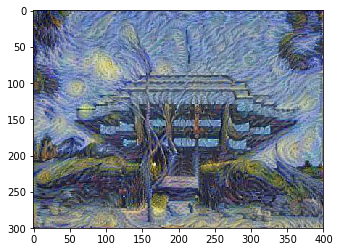

In [22]:
final_image = scipy.misc.imread("output/generated_image2.jpg")
imshow(final_image)